# Modèle 1 – Régression logistique (Attrition)

Ce notebook implémente le premier modèle supervisé du projet **HumanForYou** : la **régression logistique binaire** pour prédire l’attrition.

- **Pourquoi ce choix ?**
  - Modèle linéaire **explicable** et conforme aux exigences de transparence (AI Act, Exigence 4) détaillées dans le *Livrable 1* [^livrable1].
  - Coefficients interprétables → traduction directe en leviers RH (formation, promotion, charge de travail, satisfaction).
  - Base de comparaison robuste avant d’introduire des modèles plus complexes (Random Forest).

- **Rappels théoriques**
  - Hypothèse : \(P(Attrition=1\mid X)=\sigma(\beta_0 + \sum_i \beta_i x_i)\) avec \(\sigma\) sigmoïde.
  - Estimation par maximisation de vraisemblance (ou minimisation de la log-loss) avec régularisation **L2** pour contrôler le sur-apprentissage.
  - Interprétation : chaque \(\beta_i\) mesure l’effet marginal (odds ratio) d’une variable sur la probabilité de départ.

- **Considérations éthiques**
  - Les **variables sensibles** (Age, Gender, MaritalStatus) sont exclues du modèle, conformément au cadre RGPD/AI Act.
  - Les **proxies** (TotalWorkingYears, YearsAtCompany, MonthlyIncome, JobLevel) sont conservées pour leur légitimité métier mais feront l’objet d’une surveillance (audit d’équité a posteriori).

[^livrable1]: *Livrable 1 – IA, Éthique et Bibliographie*, CESI, 2025. Voir `docs/others/Livrable_1_Rapport_IA_éthique - Groupe Seyni.pdf`.


In [1]:
# Imports et configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
np.random.seed(42)

print(f"Exécution : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


Exécution : 2025-12-16 14:17:39


In [2]:
# Chargement des données sources
paths = {
    'general': './exploration/datasets/general_data.csv',
    'manager': './exploration/datasets/manager_survey_data.csv',
    'employee': './exploration/datasets/employee_survey_data.csv',
    'in_time': './exploration/datasets/in_time.csv',
    'out_time': './exploration/datasets/out_time.csv'
}

try:
    general_data = pd.read_csv(paths['general'])
    manager_survey = pd.read_csv(paths['manager'])
    employee_survey = pd.read_csv(paths['employee'])
    in_time = pd.read_csv(paths['in_time'])
    out_time = pd.read_csv(paths['out_time'])
    print("Fichiers chargés avec succès.")
except FileNotFoundError as e:
    raise FileNotFoundError(f"Fichier manquant : {e}")


Fichiers chargés avec succès.


In [3]:
# Fusion RH

df_merged = (
    general_data
    .merge(manager_survey, on='EmployeeID', how='left')
    .merge(employee_survey, on='EmployeeID', how='left')
)
print(f"Fusion RH : {df_merged.shape}")


Fusion RH : (4410, 29)


In [4]:
# Agrégation des horaires (MeanDailyHours, StdDailyHours, WorkedDays)

# On suppose la première colonne = EmployeeID
if not in_time.empty and not out_time.empty:
    date_cols = in_time.columns[1:]
    emp_ids = in_time.iloc[:, 0]

    in_dt = in_time.copy()
    out_dt = out_time.copy()
    in_dt[date_cols] = in_dt[date_cols].apply(pd.to_datetime, errors='coerce')
    out_dt[date_cols] = out_dt[date_cols].apply(pd.to_datetime, errors='coerce')

    daily_hours = (out_dt[date_cols] - in_dt[date_cols]) / pd.Timedelta(hours=1)

    time_features = pd.DataFrame({
        'EmployeeID': emp_ids,
        'MeanDailyHours': daily_hours.mean(axis=1),
        'StdDailyHours': daily_hours.std(axis=1).fillna(0),
        'WorkedDays': daily_hours.count(axis=1)
    })
else:
    time_features = pd.DataFrame({
        'EmployeeID': df_merged['EmployeeID'],
        'MeanDailyHours': np.nan,
        'StdDailyHours': np.nan,
        'WorkedDays': np.nan
    })

print(f"Indicateurs horaires : {time_features.shape}")


Indicateurs horaires : (4410, 4)


In [5]:
# Construction dataset final + exclusions éthiques

df_final = df_merged.merge(time_features, on='EmployeeID', how='left')

vars_sensibles = ['Age', 'Gender', 'MaritalStatus']
vars_inutiles = ['EmployeeCount', 'StandardHours', 'Over18']
a_supprimer = [v for v in vars_sensibles + vars_inutiles if v in df_final.columns]

df_model = df_final.drop(columns=a_supprimer)
print(f"Dataset modèle : {df_model.shape} (variables sensibles exclues)")


Dataset modèle : (4410, 26) (variables sensibles exclues)


In [6]:
# Imputation simple
num_cols = df_model.select_dtypes(include=[np.number]).columns
cat_cols = df_model.select_dtypes(include=['object', 'category']).columns

if df_model.isnull().sum().sum() > 0:
    if len(num_cols):
        imp_num = SimpleImputer(strategy='median')
        df_model[num_cols] = imp_num.fit_transform(df_model[num_cols])
    if len(cat_cols):
        imp_cat = SimpleImputer(strategy='most_frequent')
        df_model[cat_cols] = imp_cat.fit_transform(df_model[cat_cols])
print("Imputation terminée.")

# Feature engineering
if {'YearsAtCompany', 'TotalWorkingYears'} <= set(df_model.columns):
    df_model['TenureRatio'] = df_model['YearsAtCompany'] / (df_model['TotalWorkingYears'] + 1)
if 'NumCompaniesWorked' in df_model.columns:
    df_model['Stability'] = 1.0 / (df_model['NumCompaniesWorked'] + 1)
if {'YearsSinceLastPromotion', 'YearsAtCompany'} <= set(df_model.columns):
    df_model['PromotionGap'] = df_model['YearsSinceLastPromotion'] / (df_model['YearsAtCompany'] + 1)
if {'MeanDailyHours', 'DistanceFromHome'} <= set(df_model.columns):
    df_model['WorkLifeBalanceIndex'] = df_model['MeanDailyHours'] * df_model['DistanceFromHome']

print("Features dérivées créées.")


Imputation terminée.
Features dérivées créées.


In [7]:
# Préprocessing (standardisation + encodage) et split stratifié

X = df_model.drop(columns=['Attrition', 'EmployeeID'], errors='ignore')
y = df_model['Attrition'].map({'Yes': 1, 'No': 0}) if df_model['Attrition'].dtype == object else df_model['Attrition']

num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat_cols)
    ],
    remainder='drop'
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train/Test : {X_train.shape[0]} / {X_test.shape[0]} | Attrition train = {y_train.mean()*100:.1f}%")


Train/Test : 3528 / 882 | Attrition train = 16.1%


In [8]:
# Entraînement du modèle de régression logistique

log_reg = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf', LogisticRegression(
        penalty='l2',
        max_iter=200,
        class_weight='balanced',  # aide sur classe minoritaire
        solver='lbfgs'
    ))
])

log_reg.fit(X_train, y_train)

# Prédictions
proba_test = log_reg.predict_proba(X_test)[:, 1]
y_pred = (proba_test >= 0.5).astype(int)

# Métriques
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    'AUC': roc_auc_score(y_test, proba_test)
}
print(pd.Series(metrics).round(3))

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))


Accuracy     0.737
Precision    0.348
Recall       0.725
F1           0.470
AUC          0.796
dtype: float64

Classification report:
              precision    recall  f1-score   support

           0      0.933     0.739     0.825       740
           1      0.348     0.725     0.470       142

    accuracy                          0.737       882
   macro avg      0.641     0.732     0.648       882
weighted avg      0.839     0.737     0.768       882



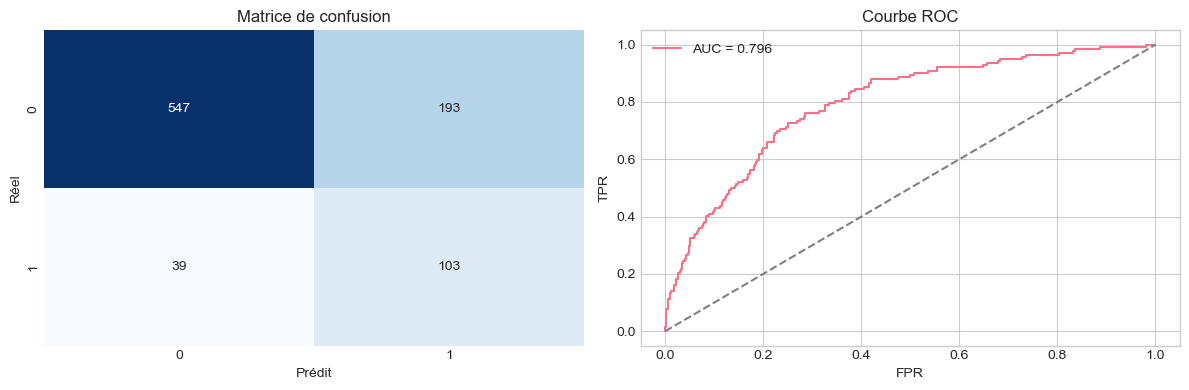

In [9]:
# Visualisations : matrice de confusion et courbe ROC

cm = confusion_matrix(y_test, y_pred)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_xlabel('Prédit')
axes[0].set_ylabel('Réel')
axes[0].set_title('Matrice de confusion')

fpr, tpr, _ = roc_curve(y_test, proba_test)
axes[1].plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, proba_test):.3f}')
axes[1].plot([0, 1], [0, 1], '--', color='gray')
axes[1].set_xlabel('FPR')
axes[1].set_ylabel('TPR')
axes[1].set_title('Courbe ROC')
axes[1].legend()

plt.tight_layout()
plt.show()


In [10]:
# Importance des variables (coefficients)

# Récupération des noms de features après encodage
feature_names = []
feature_names.extend(preprocessor.named_transformers_['num'].get_feature_names_out(num_cols))
if cat_cols:
    ohe_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
    feature_names.extend(ohe_names)

coef = log_reg.named_steps['clf'].coef_[0]
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coef': coef,
    'odds_ratio': np.exp(coef)
}).sort_values('coef', ascending=False)

print("Top facteurs de risque (coefficients positifs) :")
display(coef_df.head(10))

print("\nFacteurs protecteurs (coefficients négatifs) :")
display(coef_df.tail(10))


Top facteurs de risque (coefficients positifs) :


,feature,coef,odds_ratio
24,BusinessTravel_Travel_Frequently,1.417524,4.126888
9,YearsAtCompany,0.728839,2.072672
25,BusinessTravel_Travel_Rarely,0.654120,1.923450
17,MeanDailyHours,0.646479,1.908808
10,YearsSinceLastPromotion,0.554150,1.740461
39,JobRole_Sales Executive,0.447947,1.565095
37,JobRole_Research Director,0.421254,1.523872
33,JobRole_Human Resources,0.299341,1.348970
38,JobRole_Research Scientist,0.242911,1.274955
4,NumCompaniesWorked,0.157465,1.170539



Facteurs protecteurs (coefficients négatifs) :


,feature,coef,odds_ratio
30,EducationField_Medical,-0.406413,0.666035
15,JobSatisfaction,-0.417110,0.658949
36,JobRole_Manufacturing Director,-0.567268,0.567072
32,EducationField_Technical Degree,-0.614460,0.540933
29,EducationField_Marketing,-0.623578,0.536023
20,TenureRatio,-0.627145,0.534115
31,EducationField_Other,-0.655883,0.518984
26,Department_Research & Development,-0.949400,0.386973
27,Department_Sales,-0.977085,0.376407
7,TotalWorkingYears,-1.194378,0.302892
